In [1]:
from textfile_data import txt_parser
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mplhep as hep
import boost_histogram as bh
from plot_classes import EmptyPlot
from matplotlib import transforms
import pandas as pd
from math import ceil

In [2]:
data = txt_parser("tHbb_v31_v3.txt")
numeric_data = data.astype(float)
data0      = numeric_data[numeric_data[1] == 0]
data1      = numeric_data[(numeric_data[1] == 1) & (numeric_data.index != 'gamma_stat_SR_bin_9')]
data_gamma = numeric_data[numeric_data.index == 'gamma_stat_SR_bin_9']
data1.iloc[1:3,:]

,1,2,3
0,,,
ttb_NORM,1.0,0.189400,-0.160084
ttc_NORM,1.0,0.388419,-0.282454


In [3]:
"""
FIGSIZE DEPENDENT ON DATA SIZE + MATPLOTLIB + PANDAS
"""

class PythPullPlot(EmptyPlot):

    
    def __init__(self, pd_obj, spacing=1, **kwargs):        
        # need to take in object in constructor if we want figure size to change based on data

        super().__init__(**kwargs)
        self.fill(pd_obj)
        
        # user can either control size or the spacing but one choice excludes the other
        if 'size' in kwargs.keys():
            print('Manually changing the figure size') # need logger
        else:
            self.set_figsize(spacing) # spacing between variables for pull plot            

        self.create_canvas()
        self.make_grid()
        self.ax = self.make_subplot(0, 1, 0, 1)
        self.set_color() # set default colormap
        self.use_custom_range = False


    def set_figsize(self, spacing):
        
        # variable figure length based on number of data points
        n = self.nvariables
        ly = 0.4012*n**(0.763) # empiric formula from manually measured numbers and fitted with excel
        self.figsize = (2,ly)  # *** though, starts to deviate at around n > 140

        
    def fill(self, pd_obj):
        
        self.container1d.append(pd_obj)
        self.store_data()
    
    
    def store_data(self):
        
        self.values      = self.container1d[0][1] # pandas series
        self.pos_err     = self.container1d[0][2] # pandas series
        self.neg_err     =-self.container1d[0][3] # pandas series
        self.data_labels = self.container1d[0].index.to_list() # list
        self.nvariables  = len(self.values)
        
        # central value of the pull plot
        self.center = self.values[0]
    
    
    def set_yaxis(self, **yaxis_kw):
        
        # set numerical limits of plot
        self.ax.set_ylim(-1, self.nvariables)
        
        # put ticks on right
        self.ax.yaxis.tick_right()
        
        # default yaxis kw arguments
        self.yaxis_kw = {"fontsize": 8
        }
        self.yaxis_kw.update(yaxis_kw)
        
        # put variable names onto axis
        self.ax.set_yticks(self.ypos, labels=self.data_labels, **self.yaxis_kw)
        
    
    def set_xaxis(self, xtitle, **xlabel_kw):
        # xlabel_kw from: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html
        
        if self.use_custom_range: # if user provided x axis ranges
            xmin = self.user_xmin
            xmax = self.user_xmax
            
        else:
            # check the longest line data contains
            longest = ceil(max([max(self.neg_err), max(self.pos_err)]))
            nice_range = longest + 2
            xmin = -nice_range+self.center
            xmax = nice_range+self.center

        self.ax.set_xlim(xmin, xmax)
        self.ax.set_xticks(np.arange(xmin, xmax+1))

        # default xlabel kw arguments
        self.xlabel_kw = {"fontsize": 10
        }
        self.xlabel_kw.update(xlabel_kw)
        
        self.ax.set_xticklabels([str(int(x)) for x in np.arange(xmin, xmax+1)], **self.xlabel_kw)
        
        # axis title
        # self.ax.set_xlabel(xtitle) # position is wrong
        
        
    def set_rangex(self, range_list):
        # allow user to enter custom range for the x axis
        # range_list = [xmin, xmax]
        
        if isinstance(range_list, list) and len(range_list) == 2:
            self.range_list = range_list
            self.user_xmin = self.range_list[0]
            self.user_xmax = self.range_list[1]
            
            self.use_custom_range = True
    
    
    def pull_plot(self, titlesize, xtitle, **errorbar_kw):
        # errorbar_kw are keyword argyments from the matplotlib function ax.errorbar:
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html
        
        # define base transformations and rotation transformations
        base = self.ax.transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        # create arrays for errobar plot
        self.ypos = np.arange(self.nvariables)
        self.xerrs = pd.concat([self.neg_err, self.pos_err], axis=1).T
        
        # default plot kw arguments
        self.plot_kw = {"color"     : 'k',
                        "fmt"       : 'o',
                        "markersize": 3,
                        "elinewidth": 1
        }
        self.plot_kw.update(errorbar_kw)

        # make plot
        self.ax.errorbar(self.values, self.ypos, xerr=self.xerrs, **self.plot_kw)
        
        # put yellow and green bands
        self.ax.fill_between([-2+self.center, 2+self.center], -1, self.nvariables, color="yellow")
        self.ax.fill_between([-1+self.center, 1+self.center], -1, self.nvariables, color="limegreen")
        
        # default y axis
        self.set_yaxis()
        
        # default x axis
        self.set_xaxis(xtitle)
        
        # remove axis ticks for left and right axis of plot
        self.ax.tick_params(which="both", bottom=True, left=False, top=True, right=False)
        
        # self.ax.hlines(0, -3, 3)
        # self.ax.hlines(self.nvariables, -3, 3)
        self.ax.set_title(self.title, fontsize=titlesize)
        
        # hep.atlas.text(loc=4, ax=self.ax) # cannot position it properly

        
    def display(self, titlesize=15, xtitle="", save_name="", dpi=800, **errorbar_kw):
        
        self.pull_plot(titlesize, xtitle, **errorbar_kw)
        # self.fig.set_tight_layout(True) # tightlayout might be useful?
        
        if save_name:
            self.saveimage(save_name, dpi)
    
    
    def show_content(self):
        # print out data content of histogram and returns pandas dataframe
        pass

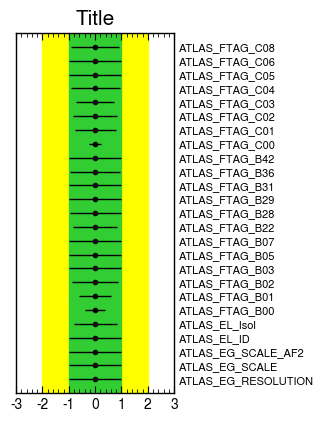

In [6]:
hist1 = PythPullPlot(data0.iloc[0:25,:], title="Title")
# hist1.set_rangex([-6, 11])
hist1.display()